In [107]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Lets import yolo 
from ultralytics import YOLO
import numpy as np


In [108]:
# Step 1: Load the pre-trained YOLO model
model = YOLO("./my_model/citizenship_detection/my_model.pt")

In [109]:
def detect_citizenship(image_path):
    image = cv2.imread(image_path)  # Read the original image
    results = model(image_path)  # Perform object detection
    
    # Step 3: Extract bounding boxes with high confidence
    cropped_images = []
    boxes_with_conf = []
    confidence_threshold = 0.5  # Set the confidence threshold
    for result in results:
        for box in result.boxes:  # Iterate over detected boxes
            if box.conf > confidence_threshold:  # Check confidence
                boxes_with_conf.append((box, float(box.conf[0])))
    
    # Sort boxes by confidence in descending order
    boxes_with_conf.sort(key=lambda x: x[1], reverse=True)
    
    # Crop images in order of confidence
    for box, _ in boxes_with_conf:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Extract box coordinates
        cropped_images.append(image[y1:y2, x1:x2])  # Crop the ROI
    
    return cropped_images[0] if cropped_images else None

In [110]:
def align_image(image, target, MAX_NUMBER_OF_FEATURES = 4000):
    # Convert the images to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    target_gray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)

    #detect orb feartures 
    orb = cv2.ORB_create(MAX_NUMBER_OF_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(image_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(target_gray, None)

    # match features
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # sort matches by score 
    matches = sorted(matches, key=lambda x: x.distance)
    # Remove not so good matches
    numGoodMatches = int(len(matches) * 0.1)
    matches = matches[:numGoodMatches]

    
    #Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt


    #find homography matrix
    homo, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    im1_reg = cv2.warpPerspective(image_gray, homo, (target_gray.shape[1], target_gray.shape[0]))

    return im1_reg


    
    

In [111]:
def preprocess_image(image):
    # Resize the image to 224x224
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    sharpened = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    resized_image = cv2.resize(sharpened, (1024, 1024))

    return resized_image


In [112]:
result_from_yolo = detect_citizenship('./images/citizenship_image/_44.jpg')
detect_citizen = im1 = cv2.cvtColor(result_from_yolo, cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(20,20))
# plt.imshow(detect_citizen)


image 1/1 d:\yolo\align_image_using_template\images\citizenship_image\_44.jpg: 480x640 1 citizenship, 183.1ms
Speed: 3.6ms preprocess, 183.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


In [113]:
#load the another image
im2 = './images/template_images/temp_1.jpg'
im2 = cv2.imread(im2, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
# plt.imshow(im2)
aligned_image = align_image(detect_citizen, im2)

In [114]:
aligned_image = cv2.cvtColor(aligned_image, cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(30,30))
# plt.imshow(aligned_image)

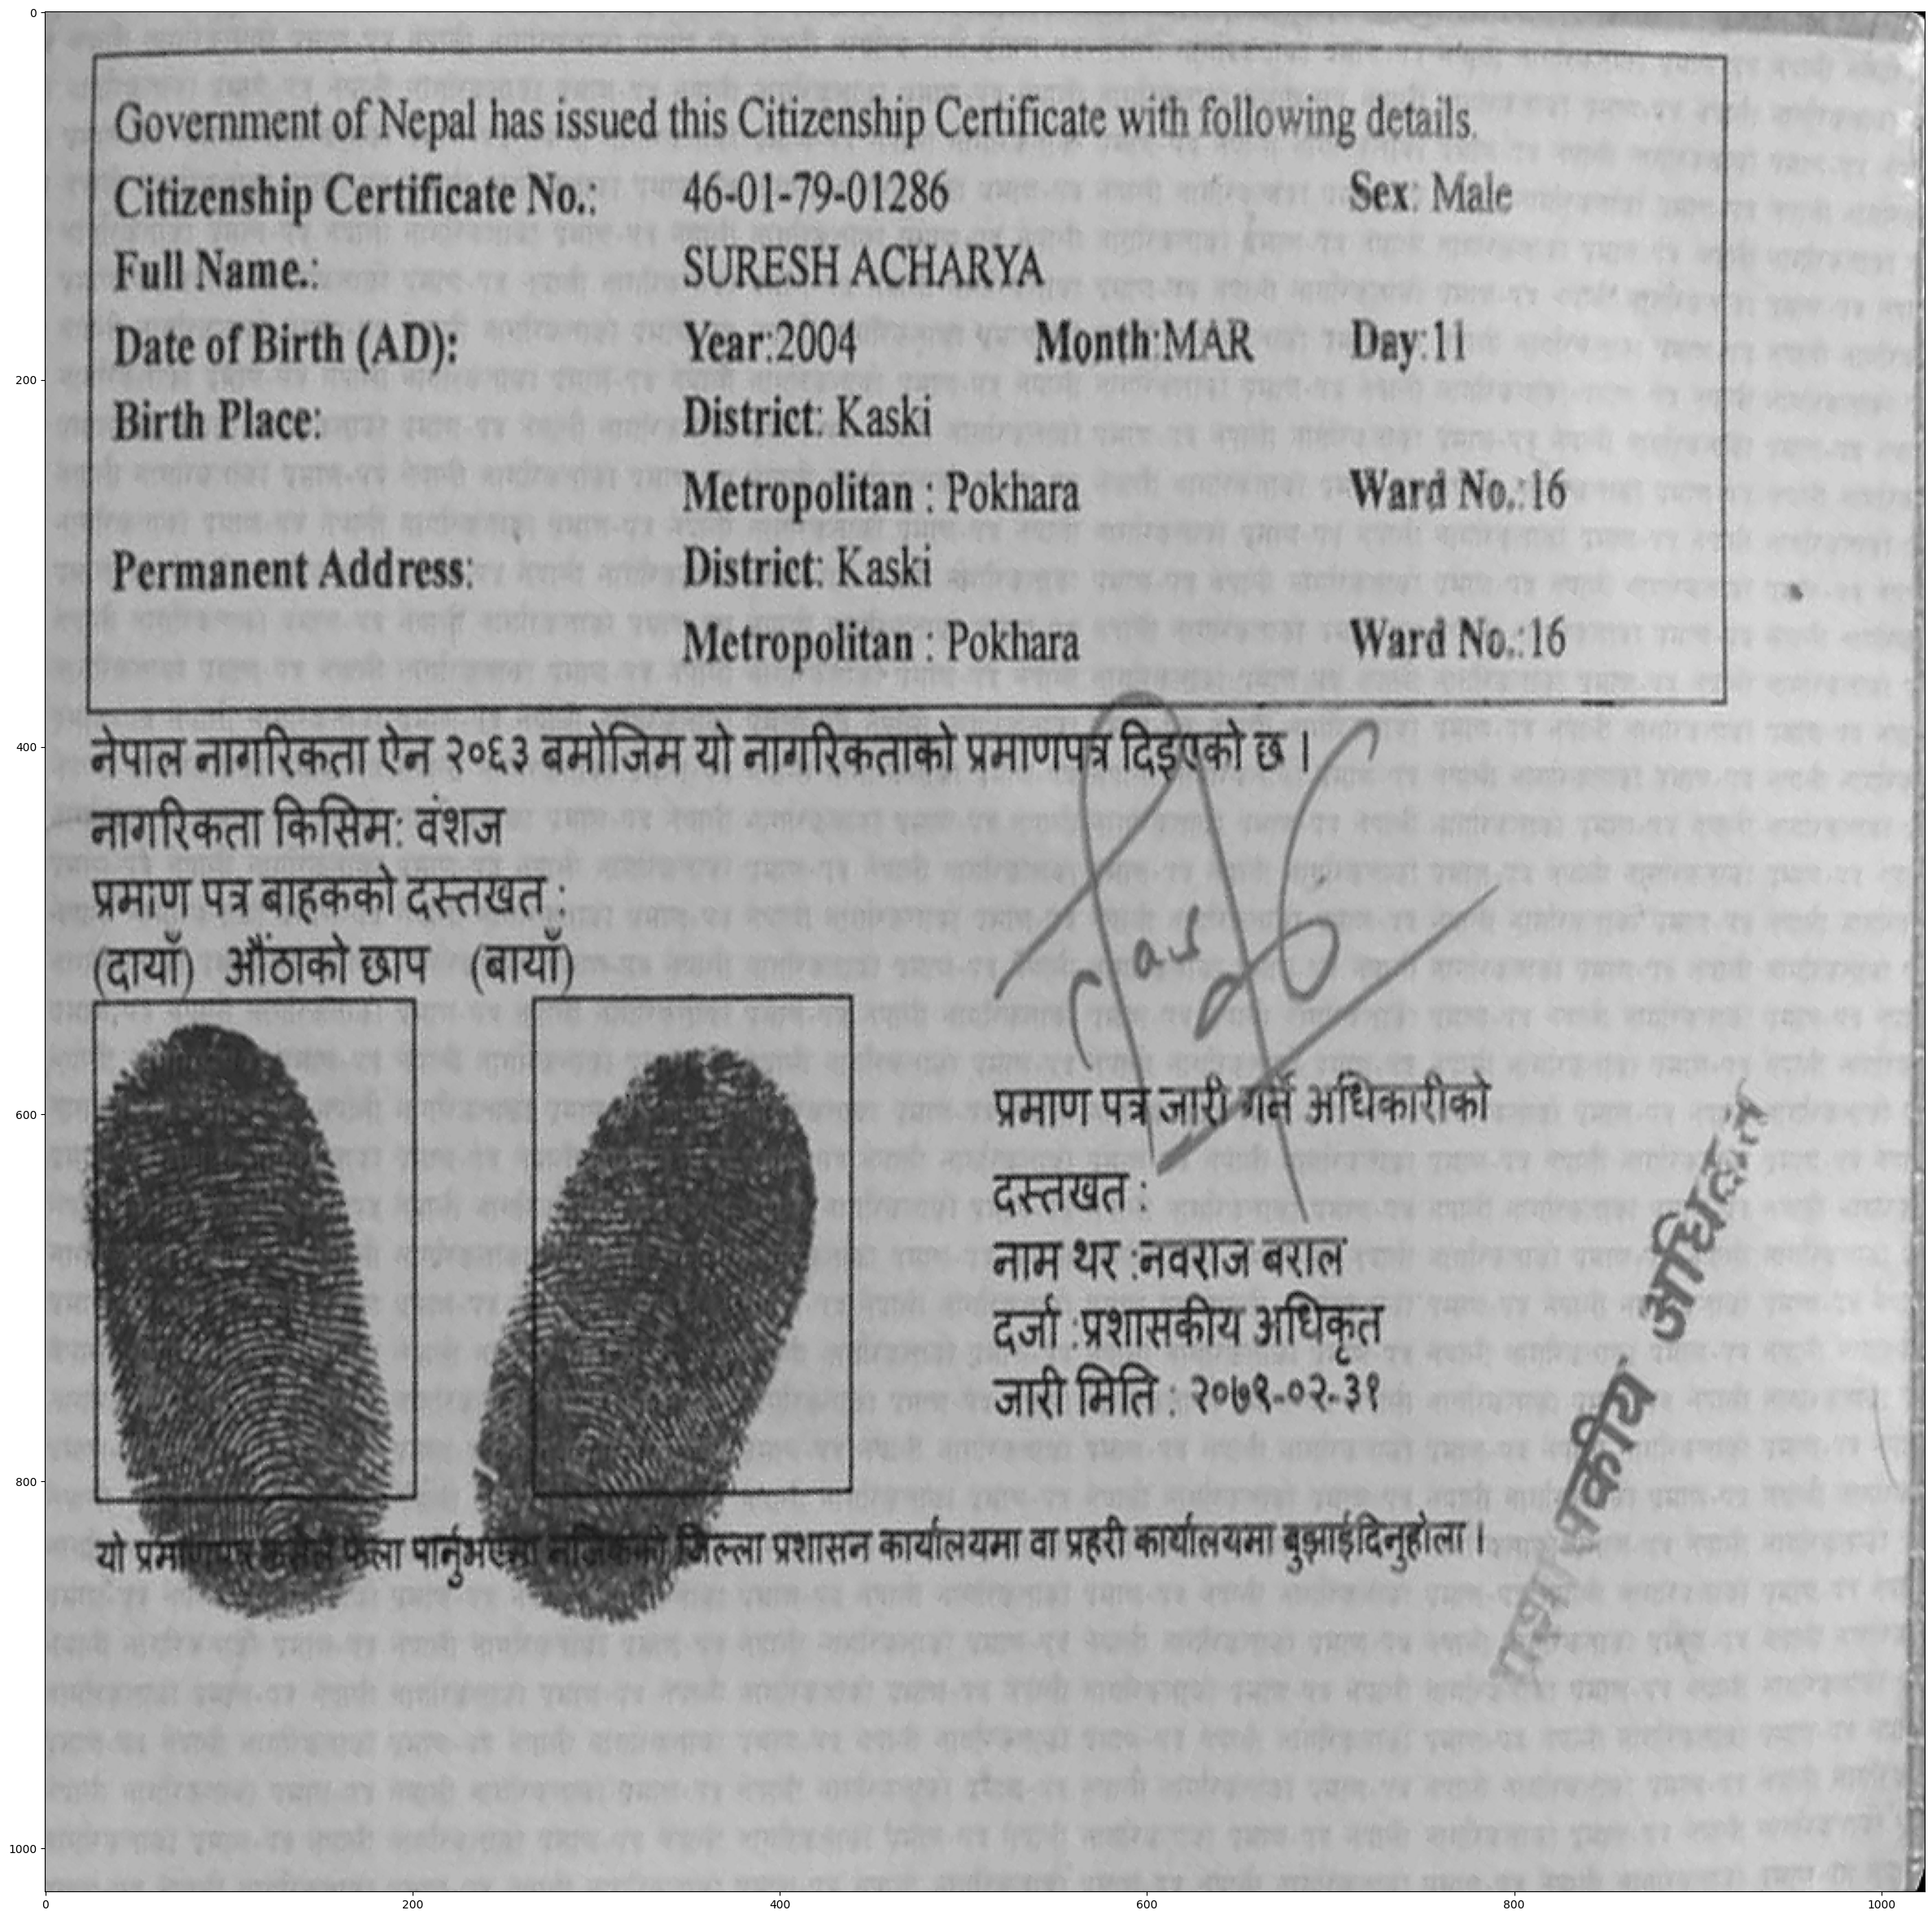

In [115]:
final_image = preprocess_image(aligned_image)
plt.figure(figsize=(30,30))
plt.imshow(final_image)

In [116]:
# Below is the code to detect the field of interest in the aligned image

In [117]:
field_detection_model = YOLO("./my_model/field_detection_model/my_model.pt")
class_names = field_detection_model.names

## Here 
1. Name: Name of the person
2. pa_ward = permanent ward no of the persom
3. citizenship_no: citizenship_no fo the person
4. dob_year: date of birth(year)
5. dob_month: date of birth (month)
6. dob_day: date of birth (day)
..lly
# pa = permanent Address
# bp = birth place address

In [118]:
# Below is the code to extract the text from the detected field of interest

In [119]:
import cv2

def get_cropped_field_dict(sharpened_image, field_detection_model, class_names, confidence_threshold=0.5):
    results = field_detection_model(sharpened_image)
    boxes_with_conf = []

    # Extract high-confidence boxes
    for result in results:
        for box in result.boxes:
            if box.conf > confidence_threshold:
                boxes_with_conf.append((box, float(box.conf[0])))

    # Sort boxes by confidence descending
    boxes_with_conf.sort(key=lambda x: x[1], reverse=True)

    # Store cropped images in a dict
    cropped_dict = {}
    for box, _ in boxes_with_conf:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cropped = sharpened_image[y1:y2, x1:x2]
        class_id = int(box.cls[0])
        label = class_names[class_id]

        if label not in cropped_dict:
            cropped_dict[label] = []
        cropped_dict[label].append(cropped)

    return cropped_dict


In [120]:
cropped_dict = get_cropped_field_dict(
    sharpened_image=final_image,
    field_detection_model=field_detection_model,
    class_names=class_names,
    confidence_threshold=0.5
)



0: 640x640 1 bamsha, 1 birth_place_district, 1 bp_metropolitan, 1 bp_ward, 1 citizenship_no, 1 dob_day, 1 dob_month, 1 dob_year, 1 issued_date, 1 name, 1 pa_district, 1 pa_metropolitan, 1 pa_ward, 1 sex, 186.8ms
Speed: 6.0ms preprocess, 186.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


In [121]:
cropped_dict = {k: v[0] for k, v in cropped_dict.items()}  # Keep only the first cropped image for each label

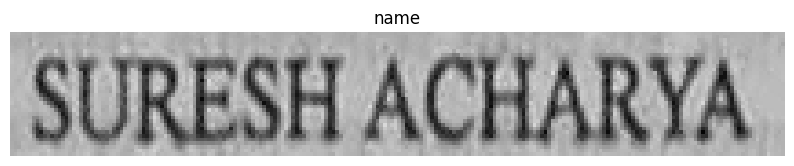

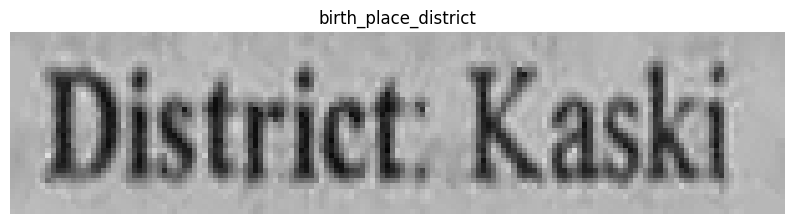

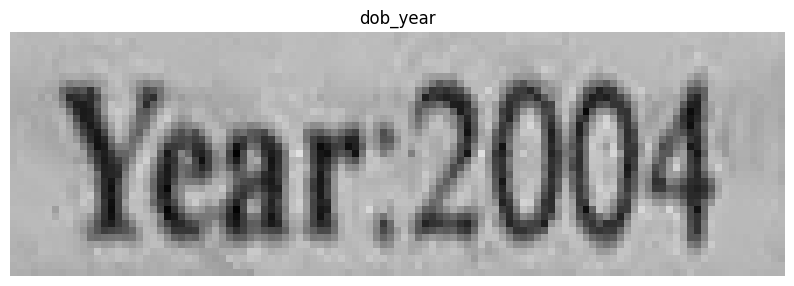

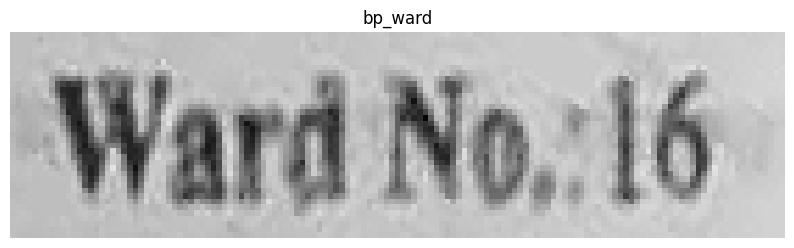

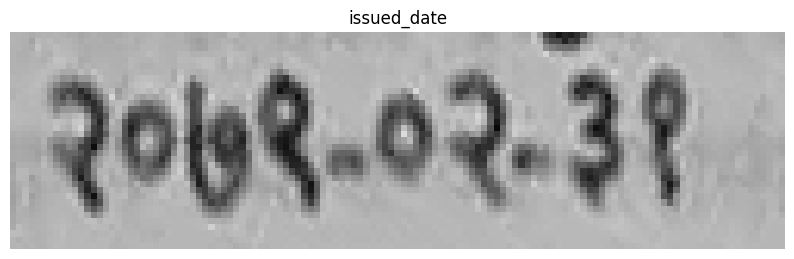

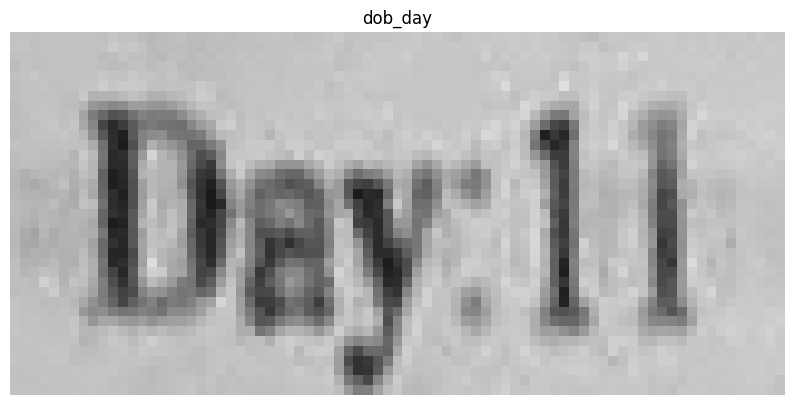

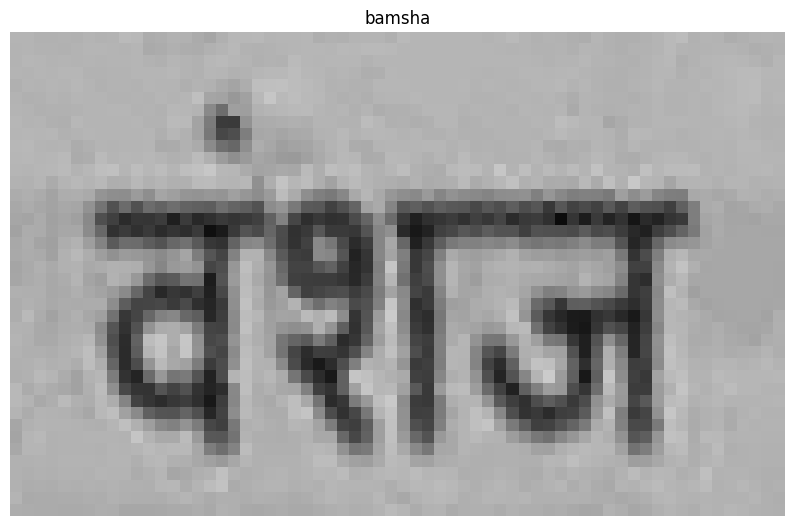

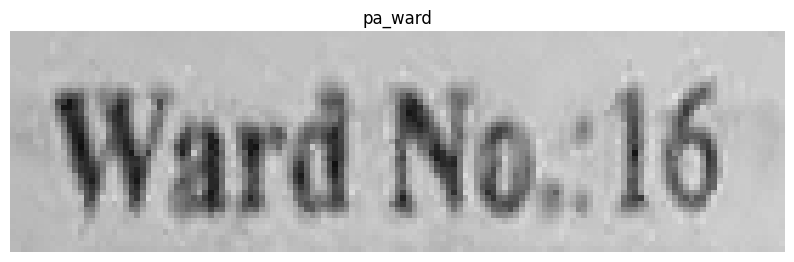

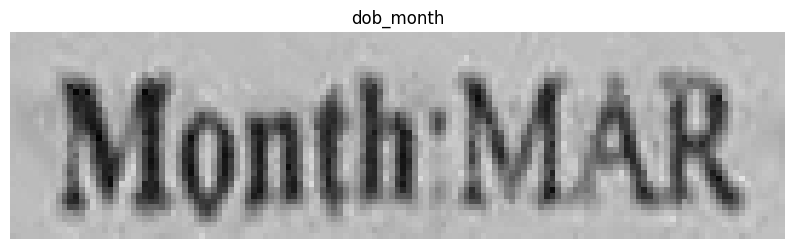

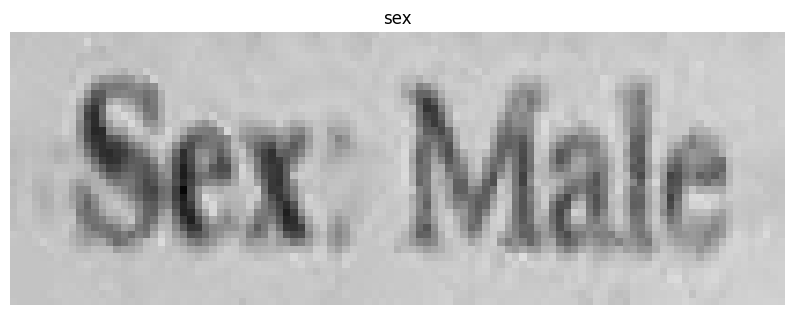

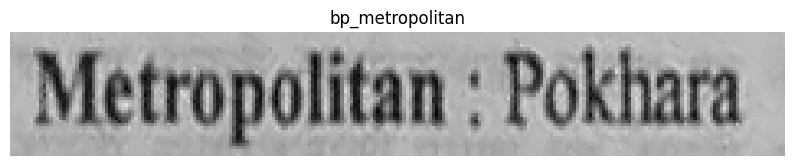

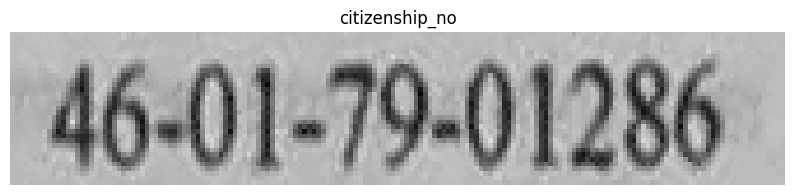

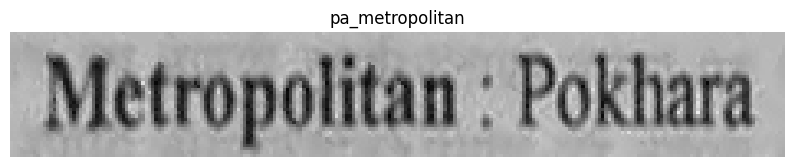

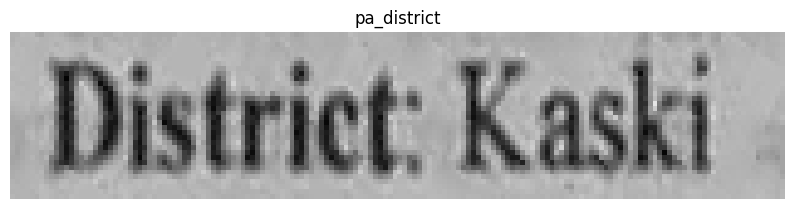

In [122]:
for label, cropped in cropped_dict.items():
    plt.figure(figsize=(10, 10))
    plt.title(label)
    plt.imshow(cropped)
    plt.axis('off')
    plt.show()  # Display each cropped image with its label

In [123]:
# Presented fields in the cititzenship document
fields = ['bamsha', 'birth_place_district', 'bp_metropolitan', 'bp_ward', 'citizenship_no', 'dob_day', 'dob_month', 'dob_year', 'issued_date', 'name', 'pa_district', 'pa_metropolitan', 'pa_ward', 'sex']

In [124]:
import cv2
import pytesseract
import numpy as np

# Set tesseract path (required on Windows)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def extract_text_from_image(image, lang='eng'):
    # 1. Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2. Resize (scale up for better OCR)
    scaled = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # 3. Denoise
    denoised = cv2.fastNlMeansDenoising(scaled, h=30)

    # 4. Adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        denoised, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        blockSize=11, C=2
    )

    # 5. Invert (Tesseract prefers black text on white bg)
    inverted = cv2.bitwise_not(thresh)

    # 6. Add border (sometimes improves OCR for edge-clipped characters)
    bordered = cv2.copyMakeBorder(inverted, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=255)

    # 7. OCR
    text = pytesseract.image_to_string(bordered, lang=lang)

    return text.strip()


In [ ]:
def extract_text_from_fields(cropped_dict, fields):
    extracted_text = {}
    for field in fields:
        if field in cropped_dict:
            image = cropped_dict.get(field)

            # Use nepali OCR for bamsha and issued_date, otherwise english
            if field in ['bamsha', 'issued_date']:
                lang = 'nep'
            else:
                lang = 'eng'

            text = extract_text_from_image(image, lang)
            extracted_text[field] = text.strip()
        else:
            extracted_text[field] = None 
    return extracted_text


In [126]:
print(extract_text_from_fields(cropped_dict, fields))

{'bamsha': 'वंशज', 'birth_place_district': 'District: Kaski', 'bp_metropolitan': 'Metropolitan : Pokhara', 'bp_ward': '', 'citizenship_no': '46-01-79-01286', 'dob_day': 'Day: 11', 'dob_month': 'Month:MAR', 'dob_year': 'Year:2004', 'issued_date': '[२०७९-०२-३१ |', 'name': 'SURESH ACHARYA', 'pa_district': 'District: Kaski', 'pa_metropolitan': 'Metropolitan : Pokhara', 'pa_ward': 'Ward No.:16', 'sex': 'Sex: Male'}
